In [83]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [84]:
from fastai.vision import *
from fastai.metrics import error_rate
from pathlib import Path
import re

In [85]:
path_img = Path("dataset_classification")
bs = 32
tfms = get_transforms(do_flip=True)
img_size = 224
resize_mode = 'zeros'

In [ ]:
data = (ImageList.from_folder(path_img, recurse=True)
                       .split_by_folder(valid='valid1')
                       .label_from_folder()
                       .transform(tfms, size=img_size, resize_method=ResizeMethod.PAD, padding_mode='zeros')
                       .databunch(bs=bs)
                       .normalize(imagenet_stats))

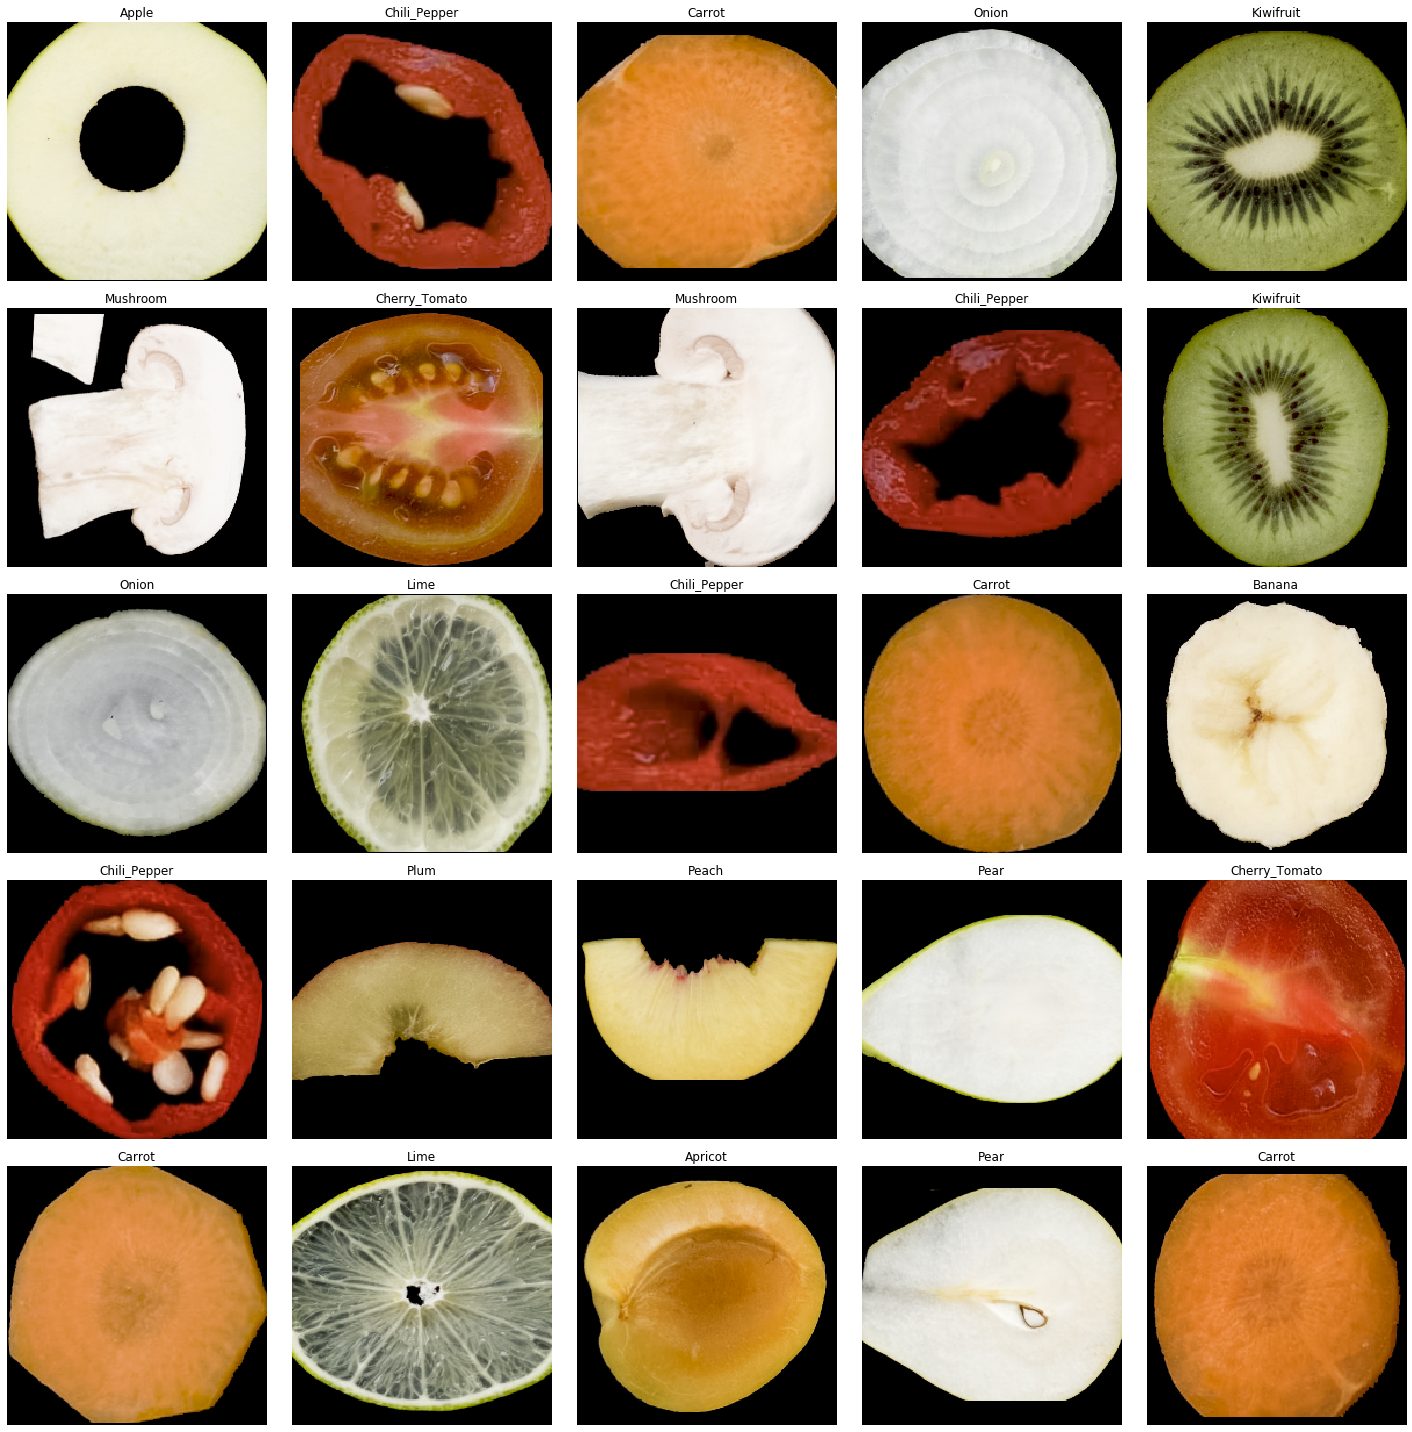

In [87]:
data.show_batch()

In [280]:
learn = cnn_learner(data, models.resnet18, metrics=error_rate)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


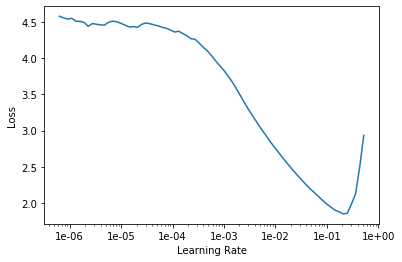

In [281]:
learn.lr_find()
learn.recorder.plot()

In [282]:
learn.fit_one_cycle(4, 1e-2)

epoch,train_loss,valid_loss,error_rate,time
0,0.769205,0.006001,0.003745,00:11
1,0.288723,0.019830,0.003745,00:11
2,0.171586,0.014901,0.007491,00:10
3,0.090367,0.000751,0.000000,00:11


In [ ]:
learn.fit_one_cycle(1, 1e-3)

In [ ]:
learn.fit_one_cycle(1, 1e-3)

In [ ]:
learn.fit_one_cycle(1, 1e-3)

In [ ]:
learn.show_results()

In [331]:
learn.export("models/Classification_resnet18_28_apr_2020.pkl")

In [367]:
learn = load_learner("dataset_classification/models", "Classification_resnet18_28_apr_2020.pkl")

In [ ]:
intrp = learn.interpret()

In [ ]:
intrp.plot_top_losses(9)

In [ ]:
intrp.plot_confusion_matrix()

In [357]:
## using 3 different validation datasets

In [418]:
def custom_data_predictions(learn, ds):
    y_true = torch.empty(len(ds), dtype=torch.int64)
    preds = torch.empty((len(ds), data.c))
    for i, (img, real) in zip(progress_bar(range(len(ds))), ds):
        pred = learn.predict(img)
        y_true[i] = int(real)
        preds[i] = pred[2]
    return preds, y_true  

class CustomDataClassIntrp(ClassificationInterpretation):
    def __init__(self, learn, ds):
        """can use a dataset different from the learner one but can't manage loss"""
        super().__init__(learn, *custom_data_predictions(learn, ds), None)
        self.ds = ds
    def error_rate(self):
        return 1 - (self.y_true == self.pred_class).float().mean()
    def probabilities(self):
        return self.preds.max(dim=1)
    def top_losses(self):
        # loss isn't returned by predict so it is set to None
        raise NotImplementedError
    def to_category(self,y):
        return [self.ds.classes[int(i)] for i in y]
    def to_df(self):
        df = pd.concat([pd.Series(o) for o in [self.to_category(self.y_true), self.to_category(self.pred_class), self.probabilities().values, (self.y_true == self.pred_class)]], axis=1)
        df.columns = ['real', 'predicted', 'probability', ' correct']
        return df

In [419]:
intrps = [CustomDataClassIntrp(learn, ImageList.from_folder(path_img/ds_folder, recurse=True)
           .split_none()
           .label_from_folder()
           .transform(size=img_size)
           .databunch(bs=bs)
           .normalize(imagenet_stats). train_ds) for ds_folder in ["valid1", "valid2", "valid3"]]

In [417]:
intrps[0].to_category(intrps[0].y_true)

In [416]:
pd.concat([pd.Series(o) for o in [[intrp.ds.classes[int(i)] for i in intrp.y_true], intrp.y_true]], axis=1)

,0,1
0,Carrot,3
1,Carrot,3
2,Onion,10
3,Banana,2
4,Plum,13
...,...,...
251,Zucchini,16
252,Pear,12
253,Plum,13
254,Onion,10


In [415]:
pd.Series([intrp.ds.classes[int(i)] for i in intrp.y_true])

0        Carrot
1        Carrot
2         Onion
3        Banana
4          Plum
         ...   
251    Zucchini
252        Pear
253        Plum
254       Onion
255      Potato
Length: 256, dtype: object

In [414]:
intrps[0].to_df()

,real,predicted,probability,correct
0,NaN,NaN,1.000000,True
1,NaN,NaN,0.999998,True
2,NaN,NaN,0.999987,True
3,NaN,NaN,0.999999,True
4,NaN,NaN,1.000000,True
...,...,...,...,...
262,NaN,NaN,1.000000,True
263,NaN,NaN,1.000000,True
264,NaN,NaN,0.999996,True
265,NaN,NaN,0.999999,True


In [422]:
[intrp.to_df().to_csv(f"classification_interpretation_valid_{i}.csv", index=False) for i, intrp in enumerate(intrps)]

[None, None, None]

In [421]:
#? dump intepreation ds for further analysis?

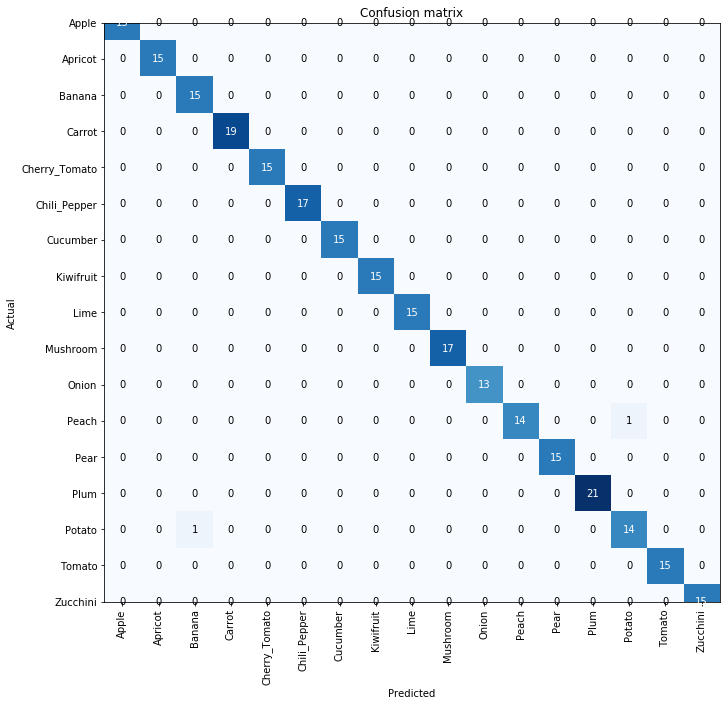

In [423]:
intrps[0].plot_confusion_matrix(figsize=(10,10))

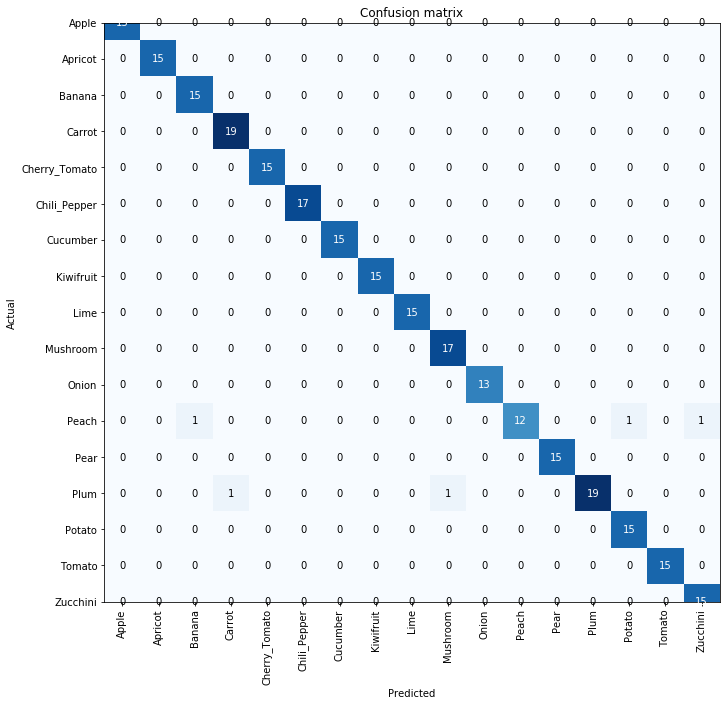

In [424]:
intrps[1].plot_confusion_matrix(figsize=(10,10))

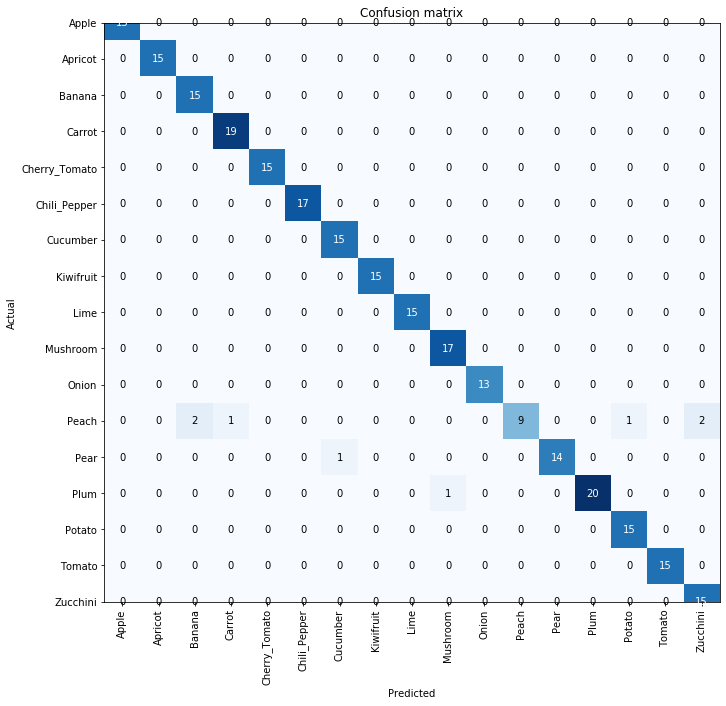

In [425]:
intrps[2].plot_confusion_matrix(figsize=(10,10))

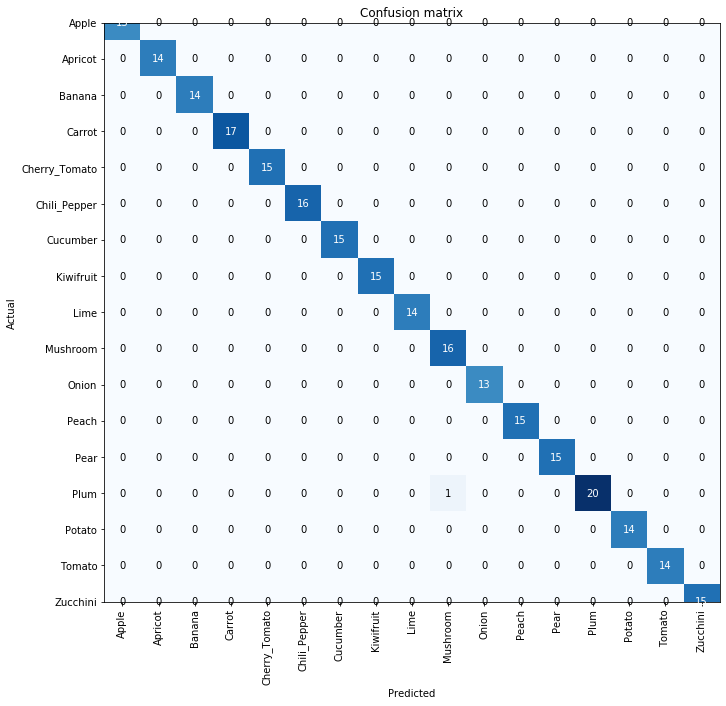

In [365]:
intrp.plot_confusion_matrix(figsize=(10,10))

## Training from scratch without imagenet

In [ ]:
data_scratch = (ImageList.from_folder(path_img, recurse=True)
                       .split_by_rand_pct()
                       .label_from_folder()
                       .transform(tfms, size=img_size, resize_method=ResizeMethod.PAD, padding_mode='zeros')
                       .databunch(bs=bs)
                       .normalize(imagenet_stats))

In [ ]:
learn_s = cnn_learner(data_scratch, models.resnet18, pretrained=False, metrics=error_rate)

In [ ]:
learn_scratch.lr_find()
learn_scratch.recorder.plot()

In [ ]:
learn_s.fit_one_cycle(5, 5e-3)

In [ ]:
learn_s.fit_one_cycle(5, 1e-3)

In [ ]:
data_scratch

In [ ]:
intrp_s = learn_s.interpret()

In [ ]:
intrp_s.plot_top_losses(9)

# Test different random splits

In [ ]:
datas = [(ImageList.from_folder(path_img, recurse=True)
                       .split_by_rand_pct(split)
                       .label_from_folder()
                       .transform(tfms, size=img_size, resize_method=ResizeMethod.PAD, padding_mode='zeros')
                       .databunch(bs=bs)
                       .normalize(imagenet_stats)) for split in list(np.arange(.2, 1, .1)) * 4]

In [ ]:
def test_traing(data, epochs=5, lr=1e-2):
    learn = cnn_learner(data, models.resnet18, metrics=error_rate)
    print("%split: ", len(data.valid_ds) /(len(data.valid_ds)+ len(data.train_ds)))
    learn.fit_one_cycle(epochs, lr)
    metrics = np.array(learn.recorder.metrics)
    learn.destroy()
    return metrics

In [ ]:
results = [test_traing(data, lr=5e-3) for data in datas]

In [ ]:
results = pd.DataFrame(np.concatenate([np.tile(np.arange(.2, 1, .1), 4).reshape((-1, 1)),np.array(results).squeeze()], axis=1))

In [ ]:
results.sort_values(1)

In [ ]:
np.array(results).shape

In [ ]:
np.arange(.2, 1, .1)[None].shape

In [ ]:
list(range(2, 9, 1))

In [ ]:
len(data.valid_ds)